In [4]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os
import seaborn as sns

import yaml
import hashlib

In [5]:
output_dir = '/Users/kumiori3/Documents/WIP/Nature/paper_IJTCAM/technology/fig'

In [6]:
class SymbolicDiscreteDamage:
    def __init__(self, matpar,  
                 name = "discrete generalised damage",
                 slug = "pw-linear"):
        self.matpar = matpar
        self.state = self.get_state(self.matpar['N'])
        self.str = name
        self.slug = slug
        self.symbols = {str(key): sp.symbols(key) for key in ["N", "γ", "w1", "E0", "L", "t"]}

    def get_state(self, N):
        u = sp.symbols([f"u{i}" for i in range(0, N)])
        e = sp.symbols([f"e{i}" for i in range(1, N+1)])
        α = sp.symbols([f"α{i}" for i in range(1, N+1)])

        state = {"u": u, "α": α, "e": e}
        return state

    def _s(self, α):
        s = sp.Function('s')
        return s(α)

    def _a(self, α):
        a = sp.Function('a')
        return a(α)
    
    def _w(self, αi):
        w = sp.Function('w')

        return w(αi)

    def energy(self):
        """Total energy"""
        return self._elastic() + self._damage() - self.work()

    def work(self):
        return 0

    def _elastic(self):
        state = self.state
        e = state["e"]
        α = state["α"]

        E0 = self.symbols["E0"]
        N = self.symbols["N"]
    
        return 1/N * sum([1./2. * E0 * self._a(α[i]) * e[i]**2 for i in range(len(α))])

    def _damage(self):
        state = self.state
        _α = state["α"]
        _w1 = self.symbols["w1"]
        N = self.symbols["N"]

        return 1/N * sum([_w1 * self._w(_α[i]) for i in range(len(_α))])

    # Explicit expressions

    def a(self, α):
        γ = self.symbols['γ']
        return (1 - self._w(α)) / ((γ-1) * self._w(α) + 1)

    def w(self, α):
        return α

    def s(self, α):
        return 1. / self.a(α)

    def boundary_condition(self):
        t, L, N = sp.symbols("t L N")

        return t*N/L       

    def __str__(self):
     return self.str
 
    def _plot_material(self, parameters):
        _damage = np.linspace(0.0, 1.0)
        alpha = sp.symbols("α")

        _a = self.a(alpha).replace(sp.Function("w"), self.w)
        _a_prime = sp.diff(_a, alpha)
        _a_prime_prime = sp.diff(_a, alpha, 2)

        _s = self.s(alpha).replace(sp.Function("w"), self.w)
        _s_prime = sp.diff(_s, alpha)
        _s_prime_prime = sp.diff(_s, alpha, 2)

        _wf = sp.lambdify(alpha, self.w(alpha).subs(parameters), "numpy")

        _af = _af = sp.lambdify(alpha, _a.subs(parameters), "numpy")
        _apf = sp.lambdify(alpha, _a_prime.subs(parameters), "numpy")
        _appf = sp.lambdify(alpha, _a_prime_prime.subs(parameters), "numpy")

        _sf = sp.lambdify(alpha, _s.subs(parameters), "numpy")
        _spf = sp.lambdify(alpha, _s_prime.subs(parameters), "numpy")
        _sppf = sp.lambdify(alpha, _s_prime_prime.subs(parameters), "numpy")

        # Plots
        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c="k")
        _ax.plot(_damage, [_af(t) for t in _damage], label="$a$")
        _ax.legend(loc=2)
        _ax.plot(_damage, [_apf(t) for t in _damage], label="$a'$")
        _ax.plot(_damage, [_appf(t) for t in _damage], label="$a''$")
        _ax2 = _ax.twiny()
        _ax2.plot(_damage, [_wf(t) for t in _damage], label="w", c="k", ls="dashed")

        _ax.set_xlim(0, 1)
        _ax2.set_xlim(0, 1)
        _ax.legend()
        _ax2.legend(loc=3)

        _ax = axis[1]

        axis[1].plot(_damage, [_sf(t) for t in _damage], label="$s$")
        axis[1].legend(loc=2)
        axis[1].axhline(0, c="k")
        axis[1].twinx()
        axis[1].plot(_damage, [_spf(t) for t in _damage], label="$s'$")
        axis[1].plot(_damage, [_sppf(t) for t in _damage], label="$s''$")
        axis[1].set_xlim(0, 1)
        axis[1].set_ylim(0, 10)
        axis[1].legend(loc=1)
        figure.suptitle(f"Behaviour of {self.__str__()} is Material")

        app_zero = sp.diff(atls.a(sp.symbols('α'))   \
            .replace(sp.Function('w'), atls.w),
            sp.symbols('α'), 2).simplify().subs(sp.symbols('α'), 0)

        spp_zero = sp.diff(atls.s(sp.symbols('α'))   \
            .replace(sp.Function('w'), atls.w),
            sp.symbols('α'), 2).simplify().subs(sp.symbols('α'), 0)

        axis[1].set_yticks([0, parameters['γ'], float(spp_zero.subs(parameters))], [0, "$\gamma$", "s''(0)"])
        axis[1].tick_params(axis='y', which='major', direction='out', length=10, width=2, colors='k')

        axis[0].set_yticks([0, -parameters['γ'], 1, float(app_zero.subs(parameters))], [0, "$-\gamma$", 1, "$a''(0)$"])
        axis[0].tick_params(axis='y', which='major', direction='out', length=10, width=2, colors='k')

        # ax[1].set_yticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
        # ax[1].tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k')

        axis[0].set_ylim(-1.3*parameters['γ'], 3.1)
        axis[1].set_ylim(0, 1.3*float(spp_zero.subs(parameters)))
        
        return figure, axis

def PwLinearQuadratic(SymbolicDiscreteDamage):
    def __init__(self, matpar,  
                 name = "discrete generalised damage",
                 slug = "pw-linear-quadratic"):
        super(PwLinearQuadratic).__init__(matpar, name, slug)




<>:136: SyntaxWarning: invalid escape sequence '\g'
<>:139: SyntaxWarning: invalid escape sequence '\g'
<>:136: SyntaxWarning: invalid escape sequence '\g'
<>:139: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/1012458051.py:136: SyntaxWarning: invalid escape sequence '\g'
  axis[1].set_yticks([0, parameters['γ'], float(spp_zero.subs(parameters))], [0, "$\gamma$", "s''(0)"])
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/1012458051.py:139: SyntaxWarning: invalid escape sequence '\g'
  axis[0].set_yticks([0, -parameters['γ'], 1, float(app_zero.subs(parameters))], [0, "$-\gamma$", 1, "$a''(0)$"])


In [7]:
import sympy as sp
import numpy as np

class ModelAnalysis:
    """Helper class to analyse (stability) properties of a model"""

    def __str__(self):
        return self.model.slug

    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

        # Define symbols
        self._β = sp.symbols("β")
        self._e = sp.symbols("e")

        # Define model-specific derivatives
        self._s = model.s(self._β)
        self._sp = sp.diff(self._s, self._β)
        self._spp = sp.diff(self._s, self._β, 2)

        self._a = model.a(self._β)
        self._ap = sp.diff(self._a, self._β)
        self._app = sp.diff(self._a, self._β, 2)

        self._w = model.w(self._β)
        self._wp = sp.diff(self._w, self._β)
        self._wpp = sp.diff(self._w, self._β, 2)

    def _state_homog_substitutions(self):
        """Substitutions for the homogeneous state"""
        state = self.state
        αt = sp.symbols("α_t")
        et = sp.symbols("e_t")

        _subs_αh = {a: αt for a in state["α"]}
        _subs_eh = {e: et for e in state["e"]}

        return _subs_αh, _subs_eh

    def _equilibrium_e(self):
        state = self.state
        t, L, N = sp.symbols("t L N")
        _S = sum([self.model._s(αi) for αi in state["α"]])

        datum = self.model.boundary_condition()

        _e = [(datum * self.model._s(αi) / _S).simplify() for αi in state["α"]]

        return _e

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state
        t, L, N = sp.symbols("t L N")

        _e0 = t / L

        _homogeneous_damage, _homogeneous_strain = self._state_homog_substitutions()

        _crit = sp.diff(
            model.energy().subs(_homogeneous_damage).subs(_homogeneous_strain),
            sp.symbols("α_t"),
        ).subs({sp.symbols("e_t"): _e0, sp.symbols("α_t"): 0})

        return _crit.simplify()

    def critical_load(self, matpar={}):
        """Critical load"""
        t = sp.symbols("t")

        criterion = (
            self.criterion()
            .replace(sp.Function("a"), self.model.a)
            .replace(sp.Function("w"), self.model.w)
            .simplify()
        )
        tc = sp.solve(criterion, t)
        _tc = [t for t in tc if sp.posify(t)[0].is_positive]
        
        if matpar:
            return [_tc.subs(matpar) for _tc in tc if _tc.subs(matpar).is_positive]

        return _tc

    def homogeneous_energy_fc_alpha(self):
        t, L, N = sp.symbols("t L N")
        _ei = self._equilibrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_homog_α, _ = self._state_homog_substitutions()
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }

        return (
            self.model.energy()
            .subs(equilibrium_subs)
            .subs(subs_homog_α)
            .subs(subs_s_inverse)
            .subs({N: self.matpar["N"]})
            .simplify()
        )

    def energy_fc_alpha(self):
        t, L, N = sp.symbols("t L N")
        _ei = self._equilibrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }

        return (
            self.model.energy()
            .subs(equilibrium_subs)
            .subs(subs_s_inverse)
            .simplify()
        )

    def _elastic_energy_fc_alpha(self):
        t, L, N = sp.symbols("t L N")
        _ei = self._equilibrium_e()
        state = self.state
        equilibrium_subs = {v[0]: v[1] for v in zip(state["e"], _ei)}
        subs_s_inverse = {
            sp.Function("a")(sp.Symbol(a.name)): 1 / self.model._s(a)
            for a in state["α"]
        }

        return (
            self.model._elastic()
            .subs(equilibrium_subs)
            .subs(subs_s_inverse)
            .simplify()
        )

    def _damage_energy_fc_alpha(self):
        return self.model._damage().simplify()

    def criterion_α(self, matpar={}):
        """Evolution law for damage"""
        αt = sp.symbols("α_t")

        subs_homog_α, _ = self._state_homog_substitutions()

        energy = (
            self.homogeneous_energy_fc_alpha()
            .replace(sp.Function("a"), self.model.a)
            .replace(sp.Function("w"), self.model.w)
            .doit()
        )

        if matpar:
            energy = energy.subs(matpar)

        return sp.diff(energy, αt)

    def homogeneous_α(self, matpar={}):
        """Solves the (homogeneous) evolution law for damage"""
        αt = sp.symbols("α_t")

        if matpar:
            return [
                sol.subs(matpar)
                for sol in map(sp.simplify, sp.solve(self.criterion_α(matpar), αt))
            ]
        else:
            return list(map(sp.simplify, sp.solve(self.criterion_α(), αt)))
            
    def homogeneous_damage(self, matpar={}):
        evos = [evo.subs(matpar) for evo in self.homogeneous_α(matpar)]
        idx = self.positive_solution_wrt_t(evos, matpar)
        evo_x = evos[idx].subs(matpar)
        
        _alpha = self.homogeneous_α(matpar)[idx].subs(matpar)
        tc = self.critical_load(matpar)[0]
        t = sp.symbols("t")

        alpha = sp.Piecewise((_alpha, t >= tc), (0, t < tc))

        return alpha

    def _stress(self):
        alpha = self.homogeneous_damage(self.matpar)
        E0 = self.model.symbols["E0"]
        
        tc = self.critical_load(self.matpar)[0]
        _S = sum([self.model._s(αi) for αi in self.state["α"]])
        stress_alpha = E0 * self.model.boundary_condition() / _S

        return stress_alpha

    def positive_solution_wrt_t(self, f, _matpar={}):
        idx = np.where(
            np.array([sp.diff(_f.subs(_matpar), sp.symbols("t")) for _f in f]) > 0
        )[0]
        return idx[0]

    def _state_split(self, m, matpar = {}):
        """Split the state into homogeneous and bifurcated parts"""
        state = self.state
        if not matpar:
            matpar = self.matpar
            
        assert m < matpar['N']

        _bif_α = [state["α"][k + 1] for k in range(m)]
        _bif_e = [state["e"][k + 1] for k in range(m)]

        _homo_α = set(state["α"]) - set(_bif_α)
        _homo_e = set(state["e"]) - set(_bif_e)

        return _bif_α, _homo_α, _bif_e, _homo_e


    def _state_bifurcation_substitutions(self, m, matpar = {}):
        """Computes substitutions for bifurcated states"""
        if not matpar:
            matpar = self.matpar
        assert m <= matpar['N']
        _bif, _homo, _bif_e, _homo_e = self._state_split(m, matpar)
        _αb = sp.symbols("α_t")
        _eb = sp.symbols("e_t")
        αt = sp.symbols("α^*")
        et = sp.symbols("e^*")

        _subs_αb = {a: _αb for a in _bif}
        _subs_eb = {e: _eb for e in _bif_e}

        _subs_αt = {a: αt for a in _homo}
        _subs_et = {e: et for e in _homo_e}

        return {**_subs_αb, **_subs_αt}, {**_subs_eb, **_subs_et}

    def _elastic_energy_m_bifurcations(self):
        n = len(self.state["α"])
        m = sp.symbols("m")
        N = sp.symbols("N")
        _s = sp.Function("s")
        E0 = self.model.symbols["E0"]
        t = self.model.symbols["t"]
        L = self.model.symbols["L"]

        at = sp.symbols("α_t")
        ax = sp.symbols("α^*")
        return 1.0 / 2.0 * E0 * (N * t / L) ** 2 * 1 / ((N - m) * _s(ax) + m * _s(at))

    def energy_m_bifurcations(self):
        # n = len(self.state["α"])
        m = sp.symbols("m")
        N = self.model.symbols["N"]
        at = sp.symbols("α_t")
        ax = sp.symbols("α^*")

        return self._elastic_energy_m_bifurcations() + self.model.symbols["w1"] * (
            m * self.model.w(at) + (N - m) * self.model.w(ax)
        )

    def elastic_energy_xi_bifurcations(self):
        n = len(self.state["α"])
        N = sp.symbols('N')
        _s = sp.Function('s')
        
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        xi = sp.symbols('xi')
        E0 = self.model.symbols["E0"]
        t = self.model.symbols["t"]
        L = self.model.symbols["L"]
        return 1./2. * E0 * (t / L)**2 * 1 / (_s(ax) + (xi)*(_s(at)-_s(ax)))
        
    def energy_xi_bifurcations(self):
        n = len(self.state["α"])
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        N = sp.symbols('N')
        xi = sp.symbols('xi')
        
        return self.elastic_energy_xi_bifurcations() +   \
            self.model.symbols["w1"] * (xi * self.model.w(at) + (1-xi) * self.model.w(ax))

    def damage_energy_xi_bifurcations(self):
        n = len(self.state["α"])
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        N = sp.symbols('N')
        xi = sp.symbols('xi')
        
        return self.model.symbols["w1"] * (xi * self.model.w(at) + (1-xi) * self.model.w(ax))

    def diff_energy_xi_bifurcations(self):
        n = len(self.state["α"])
        n = N
        # _s = model.model.s
        _s = sp.Function('s')
        
        at = sp.symbols('α_t')
        ax = sp.symbols('α^*')
        xi = sp.symbols('xi')
        E0 = self.model.symbols["E0"]
        t = self.model.symbols["t"]
        L = self.model.symbols["L"]
        
        return - 1./2. * E0 * (t / L)**2 * xi * sp.diff(_s(at), at) / ((_s(ax) + (xi)*(_s(at)-_s(ax))))**2 + \
            self.model.symbols["w1"] * (xi * sp.diff(self.model.w(at), at) ) 

    def bifurcation_m_criterion(self, matpar={}, a_subs = {sp.symbols('α^*'): sp.symbols('α^*')}):

        bif_crit_m = sp.diff(
            self.energy_m_bifurcations() \
            , sp.symbols('α_t')).subs(a_subs)                        \
                .replace(sp.Function('s'), self.model.s)      \
                .replace(sp.Function('w'), self.model.w)             \
                .simplify()
        # if a_star:
            # bif_crit_m = bif_crit_m.subs(sp.symbols('α^*'), 0)
             
        return bif_crit_m

 
    def plot_material(self, parameters):
        self.model._plot_material(parameters)



In [8]:
N = sp.symbols("N")
t = sp.symbols('t')
γ = sp.symbols('γ')
E0, L, w1, σc = sp.symbols('E0 L w1 σc')

_N = 3
_normalise = {E0: 1, w1: 1, L: 1}

_α = sp.symbols("α")
β = sp.symbols('β')


_matpar = {"N": _N, "γ": 6, "E0": 1, "w1": 3, "L": 1}
# matpar = {"N": N, "γ": γ, "E0": E0, "w1": w1, "L": L}

atls = SymbolicDiscreteDamage(_matpar)
model = ModelAnalysis(atls)

model.criterion()


1.5*E0*t**2*Subs(Derivative(a(α_t), α_t), α_t, 0)/(L**2*N) + 3*w1*Subs(Derivative(w(α_t), α_t), α_t, 0)/N

### Critical load

In [9]:
model.critical_load()

[1.4142135623731*L*sqrt(w1/(E0*γ))]

In [10]:
model.critical_load(matpar=_matpar)

[0.707106781186547*sqrt(2)]

Text(0.5, 1.0, 'Critical load vs.  - Model: pw-linear')

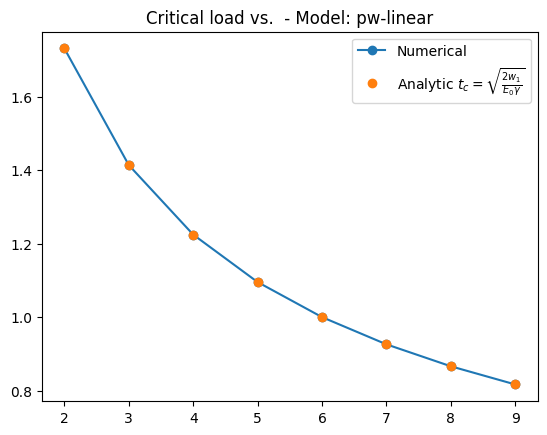

In [13]:
critical_loads = []
parameters = _matpar.copy()

for gamma in range(2, 10):
    parameters.update({γ: gamma})
    # print(model.critical_load(matpar=parameters)
    tc = model.critical_load(matpar=parameters)[0]
    _w1 = parameters["w1"]
    _E0 = parameters["E0"]
    critical_loads.append({"γ": gamma, "tc": tc, "tc_analytical": sp.sqrt(2.*_w1/(gamma*_E0))})


fig, ax = plt.subplots()
ax.plot([d["γ"] for d in critical_loads], [d["tc"] for d in critical_loads], label="Numerical", marker='o')
ax.plot([d["γ"] for d in critical_loads], [d["tc_analytical"] for d in critical_loads], label="Analytic $t_c=\\sqrt{\\frac{2w_1}{E_0 \\gamma}}$", marker='o', ls='')
plt.legend()
ax.set_title(f'Critical load vs.  - Model: {atls.slug}')

In [14]:
model.energy_fc_alpha()

(0.5*E0*N**2*t**2 + L**2*w1*(s(α1) + s(α2) + s(α3))*(w(α1) + w(α2) + w(α3)))/(L**2*N*(s(α1) + s(α2) + s(α3)))

In [15]:
model.homogeneous_energy_fc_alpha()

0.5*E0*t**2*a(α_t)/L**2 + w1*w(α_t)

### Homogeneous solution

<>:19: SyntaxWarning: invalid escape sequence '\g'
<>:19: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/2082593870.py:19: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])


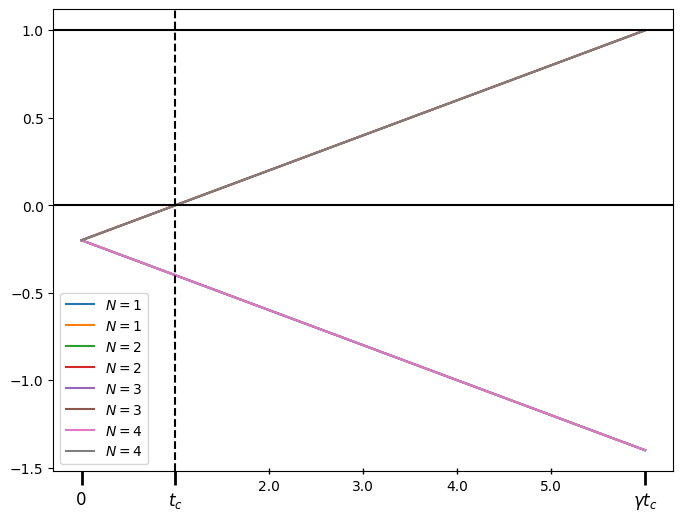

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
parameters = _matpar.copy()

for _N in range(1, 5):
    parameters.update({N: _N})
    tc = model.critical_load(matpar=parameters)[0]
    _loads = np.linspace(0., float(parameters['γ'] * tc), 30)
    atls = SymbolicDiscreteDamage(parameters, _N)
    model = ModelAnalysis(atls)
    evos = [evo.subs(parameters) for evo in model.homogeneous_α(_matpar)]
    idx = model.positive_solution_wrt_t(evos, parameters)
    evo_x = evos[idx].subs(parameters)

    for alphas in evos:
        _f = sp.lambdify(t, alphas.subs(parameters), 'numpy')
        plt.plot(_loads, _f(_loads), label=f"$N={_N}$")
    

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k', labelsize=10)

ax.axvline(float(tc), c='k', ls='--')
ax.axhline(0, c='k')
ax.axhline(1, c='k')
ax.legend()
    

In [17]:
model.homogeneous_energy_fc_alpha()    \
                .replace(sp.Function('a'), model.model.a) \
                .replace(sp.Function('w'), model.model.w)  \
                .replace(sp.Function('s'), atls.s)      

0.5*E0*t**2*(1 - α_t)/(L**2*(α_t*(γ - 1) + 1)) + w1*α_t

In [18]:
evo_x

0.2*t - 0.2

<>:33: SyntaxWarning: invalid escape sequence '\g'
<>:33: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/3489261842.py:33: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])


Text(0.5, 0, 't')

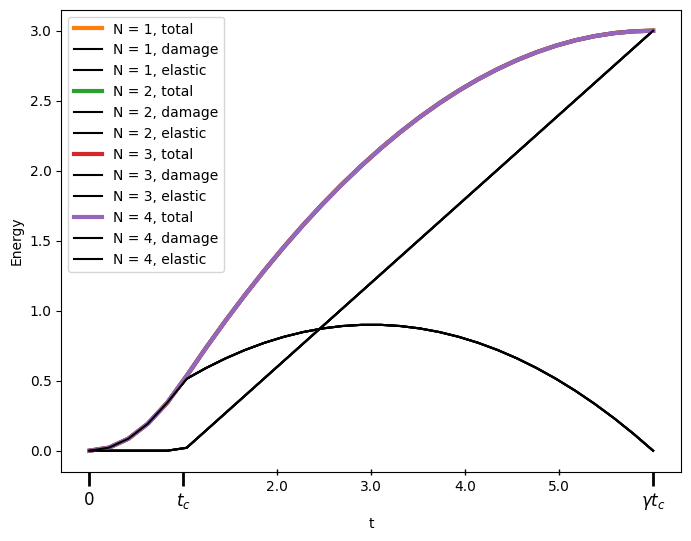

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
parameters = _matpar.copy()
_loads = np.linspace(0., float(parameters['γ'] * tc), 30)

for _N in range(1, 5):
    parameters.update({N: _N})


    atls = SymbolicDiscreteDamage(parameters, _N)
    model = ModelAnalysis(atls)

    alpha = model.homogeneous_damage(parameters)
    
    _en = model.homogeneous_energy_fc_alpha()    \
                .replace(sp.Function('a'), model.model.a) \
                .replace(sp.Function('s'), model.model.s)      \
                .replace(sp.Function('w'), model.model.w)  \
                .subs(_matpar)          \
        .subs({sp.symbols('α_t'): alpha})
    
    subs_homog_α, _ = model._state_homog_substitutions()

    _energy_damage = model.model._damage().subs(subs_homog_α).subs(_matpar) \
                .replace(sp.Function('w'), model.model.w)  \
                .subs({sp.symbols('α_t'): alpha})

    _f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
    _f1 = sp.lambdify(t, _energy_damage, 'numpy')
    ax.plot(_loads, _f(_loads), label=f'N = {_N}, total', lw=3, c='C'+str(_N))
    ax.plot(_loads, _f1(_loads), c='k', label=f'N = {_N}, damage')
    ax.plot(_loads, _f(_loads)-_f1(_loads), c='k', label=f'N = {_N}, elastic')
    
ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k', labelsize=10)

ax.legend()
ax.set_ylabel('Energy')
ax.set_xlabel('t')
# plt.savefig(os.path.join(output_dir, 'Energy-homogeneous_damage-crit.png'))

<>:25: SyntaxWarning: invalid escape sequence '\g'
<>:25: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/2021926914.py:25: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
<lambdifygenerated-17>:2: RuntimeWarning: divide by zero encountered in divide
  return 0.111111111111111*(1 - select([greater_equal(t, 0.707106781186547*sqrt(2)),True], [0.2*t - 0.2,0], default=nan))*(4.5*t**2 + 27.0*(5*select([greater_equal(t, 0.707106781186547*sqrt(2)),True], [0.2*t - 0.2,0], default=nan) + 1)*select([greater_equal(t, 0.707106781186547*sqrt(2)),True], [0.2*t - 0.2,0], default=nan)/(1 - select([greater_equal(t, 0.707106781186547*sqrt(2)),True], [0.2*t - 0.2,0], default=nan)))/(5*select([greater_equal(t, 0.707106781186547*sqrt(2)),True], [0.2*t - 0.2,0], default=nan) + 1)
<lambdifygenerated-17>:2: RuntimeWarning: invalid value encountered in multiply
  ret

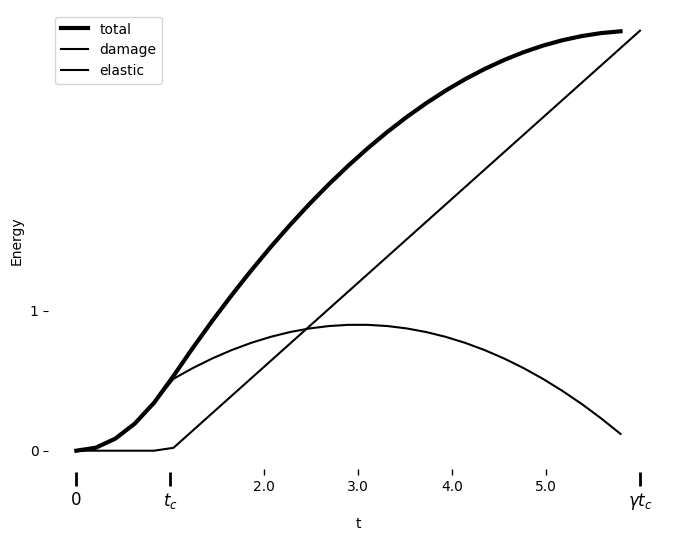

In [20]:
_en = model.energy_fc_alpha().subs(subs_homog_α)    \
            .subs(_matpar) \
            .replace(sp.Function('a'), model.model.a) \
            .replace(sp.Function('s'), model.model.s)      \
            .replace(sp.Function('w'), model.model.w)  \
            .subs(_matpar)          \
    .subs({sp.symbols('α_t'): alpha})

_energy_damage = model.model._damage().subs(subs_homog_α).subs(_matpar) \
            .replace(sp.Function('w'), model.model.w)  \
            .subs({sp.symbols('α_t'): alpha})

_f = sp.lambdify(t, _en.subs(_matpar), 'numpy')
_f1 = sp.lambdify(t, _energy_damage, 'numpy')
figure, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(_loads, _f(_loads), c='k', label='total', lw=3)
ax.plot(_loads, _f1(_loads), c='k', label='damage')
ax.plot(_loads, _f(_loads)-_f1(_loads), c='k', label='elastic')

ax.legend()
plt.ylabel('Energy')
plt.xlabel('t')

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k', labelsize=10)

plt.yticks([0, 1])

for key, spine in ax.spines.items():
    spine.set_visible(False)

# plt.savefig(os.path.join(output_dir, 'Energy-homogeneous_damage-crit.png'))

_en_homogeneous_t = _f



### Stress

In [21]:
model.homogeneous_damage(_matpar)

Piecewise((0.2*t - 0.2, t >= 0.707106781186547*sqrt(2)), (0, True))

In [22]:
tc = model.critical_load(_matpar)[0]
tc

0.707106781186547*sqrt(2)

In [23]:
_S = sum([model.model._s(αi) for αi in model.state["α"]])
_S

stress = model.model.boundary_condition() / _S
stress


N*t/(L*(s(α1) + s(α2) + s(α3)))

In [24]:
model._stress()

E0*N*t/(L*(s(α1) + s(α2) + s(α3)))

<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/152526536.py:14: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xticks([0, float(tc), parameters['γ']*float(tc), parameters['γ']*float(tc)/parameters['N']], [0, "$t_c$", "$\gamma t_c$", "$\gamma t_c/N$"])
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/152526536.py:14: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xticks([0, float(tc), parameters['γ']*float(tc), parameters['γ']*float(tc)/parameters['N']], [0, "$t_c$", "$\gamma t_c$", "$\gamma t_c/N$"])


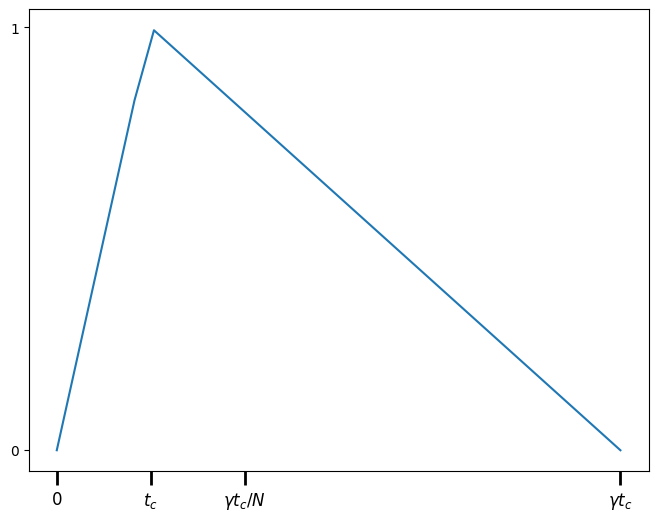

In [25]:
subs_homog_α, _ = model._state_homog_substitutions()
alpha = model.homogeneous_damage(_matpar)
_loads = np.linspace(0., float(parameters['γ'] * tc), 30)
stress = model._stress().subs(subs_homog_α) \
    .subs({sp.symbols('α_t'): alpha}) \
        .replace(sp.Function('s'), model.model.s) \
        .replace(sp.Function('w'), model.model.w) \
        .subs(_matpar)
        
stress_f = sp.lambdify(t, stress, 'numpy')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(_loads, stress_f(_loads), label='stress')
ax.set_xticks([0, float(tc), parameters['γ']*float(tc), parameters['γ']*float(tc)/parameters['N']], [0, "$t_c$", "$\gamma t_c$", "$\gamma t_c/N$"])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)
    


## Bifurcations

In [26]:
# we bifurcate m springs

m = 1

assert m < _matpar["N"]

In [27]:
model.energy_m_bifurcations()

0.5*E0*N**2*t**2/(L**2*(m*s(α_t) + (N - m)*s(α^*))) + w1*(m*α_t + α^**(N - m))

In [28]:
# model._diff_energy_m_bifurcations(sp.symbols('m'))

In [29]:
bif_crit_m = sp.diff(
    model.energy_m_bifurcations().subs({sp.symbols('α^*'): 0}) \
    , sp.symbols('α_t'))                        \
        .replace(sp.Function('s'), atls.s)      \
        .replace(sp.Function('w'), model.model.w)             \
        .simplify()

bif_crit_m

-0.5*E0*N**2*m*t**2*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(-N*α_t + N + m*α_t*γ)**2) + 1.0*m*w1

In [30]:
model.elastic_energy_xi_bifurcations()

0.5*E0*t**2/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*)))

In [31]:
model.energy_xi_bifurcations()


0.5*E0*t**2/(L**2*(xi*(-s(α^*) + s(α_t)) + s(α^*))) + w1*(xi*α_t + α^**(1 - xi))

In [32]:
bif_crit_xi = sp.diff(
    model.energy_xi_bifurcations()   \
    .subs({sp.symbols('α^*'): 0}) \
        , sp.symbols('α_t'))    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(sp.Function('w'), model.model.w)         \
        .simplify()

bif_crit_xi

-0.5*E0*t**2*xi*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(xi*α_t*γ - α_t + 1)**2) + 1.0*w1*xi

0.752241256581434*sqrt(2)*t + 1.06382978723404
0.804089864890713*sqrt(2)*t + 1.1371547922952
0.863614962067319*sqrt(2)*t + 1.22133599202393
0.932657665629632*sqrt(2)*t + 1.31897711978466
1.01369901340377*sqrt(2)*t + 1.43358689291984
1.11016444338804*sqrt(2)*t + 1.57000961230375
1.22692040644975*sqrt(2)*t + 1.73512747875354
1.37112118235619*sqrt(2)*t + 1.93905817174515
1.5537323891543*sqrt(2)*t + 2.19730941704036
1.79245899007454*sqrt(2)*t + 2.53491981376099
2.11786260868831*sqrt(2)*t + 2.99511002444988
2.5876200357088*sqrt(2)*t + 3.65944734876774
3.32516624550296*sqrt(2)*t + 4.70249520153551
4.65076943330749*sqrt(2)*t + 6.57718120805369
7.73398041922787*sqrt(2)*t + 10.9375
22.9458491908217*sqrt(2)*t + 32.4503311258277
23.731665943932*sqrt(2)*t - 33.5616438356163
7.82127139461418*sqrt(2)*t - 11.0609480812641
4.68219355110011*sqrt(2)*t - 6.62162162162162
3.3411988696375*sqrt(2)*t - 4.725168756027
2.59731876147982*sqrt(2)*t - 3.67316341829086
2.12435513661195*sqrt(2)*t - 3.00429184549356


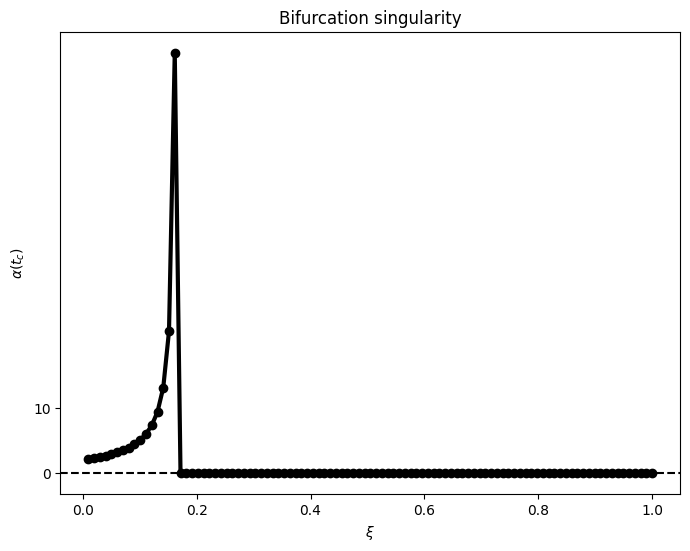

In [33]:
sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_sequence = np.linspace(0.01, 1, 99)
parameters = _matpar.copy()

alpha_bif = []
tc = model.critical_load(parameters)[0]

# for _xi in [1/3, 1/4, 1/5, 2/5, 3/5, 9/10, 8/9, 4/5]:
for _xi in _sequence:
    parameters.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(parameters) for sol in sols]
    idx = model.positive_solution_wrt_t(_sols, _matpar)
    print(_sols[idx].subs(sp.symbols('xi'), _xi))
    alpha_bif.append({'alpha(tc)': _sols[idx].subs(sp.symbols('xi'), _xi).subs(t, tc), 'xi': _xi})

alpha_bif

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot([a['xi'] for a in alpha_bif], [a['alpha(tc)'] for a in alpha_bif], marker='o', c='k', lw=3)
plt.title('Bifurcation singularity')
plt.xlabel('$\\xi$')
plt.ylabel('$\\alpha(t_c)$')
ax.set_yticks([0, 10])
# ax.set_xticks([0, 1, 1/3])
# ax.axvline(tc, c='k', ls='--')
ax.axhline(0, c='k', ls='--')
# plt.semilogy()
# fig.savefig(os.path.join(output_dir, 'bifurcation-sing.png'))


<>:36: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/4125659196.py:36: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])


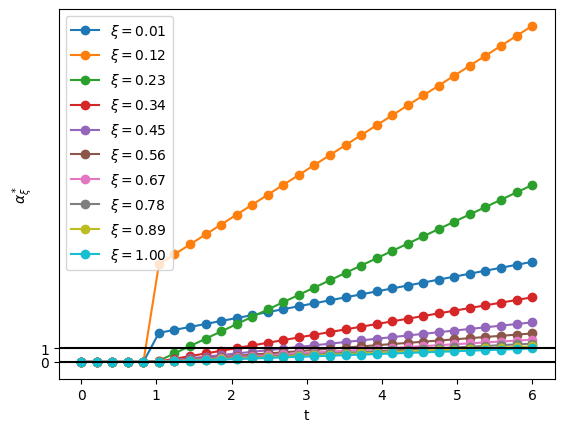

In [34]:
# sp.latex(
sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
parameters = _matpar.copy()
_sequence = np.linspace(0.01, 1, 10)

tc = model.critical_load(parameters)[0]
_loads = np.linspace(0., float(parameters['γ'] * tc), 30)


# fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# _sequence = np.linspace(0.001, 1, 10)

# # for _xi in [1/3, 1/4, 1/5, 2/5, 3/5, 9/10, 8/9, 4/5]:
for _xi in _sequence:
    parameters.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(parameters) for sol in sols]
    idx = model.positive_solution_wrt_t(_sols, _matpar)
    # print(idx)
#     idx = pos[0][0]
    # for sol in _sols[idx]:
#     # print(_sols[idx].subs(sp.symbols('xi'), _xi))
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
#     # _f = sp.lambdify(t, _sols[idx], 'numpy')
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    plt.plot(_loads, _f(_loads), label=f'$\\xi = {_xi:.2f}$', marker='o')
plt.axhline(0, c='k')
plt.axhline(1, c='k')
plt.legend()
plt.ylabel('$\\alpha_\\xi^*$')
plt.xlabel('t')
# plt.xticks([0, 1, _matpar[γ]], ['0', '$t_c$', '$\\gamma$'])
plt.yticks([0, 1])
# plt.ylim(-.1, 2.1)

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k', labelsize=10)

# fig.savefig(os.path.join(output_dir, 'bifurcation-sing.png'))


<>:35: SyntaxWarning: invalid escape sequence '\g'
<>:35: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/4266290390.py:35: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])


0

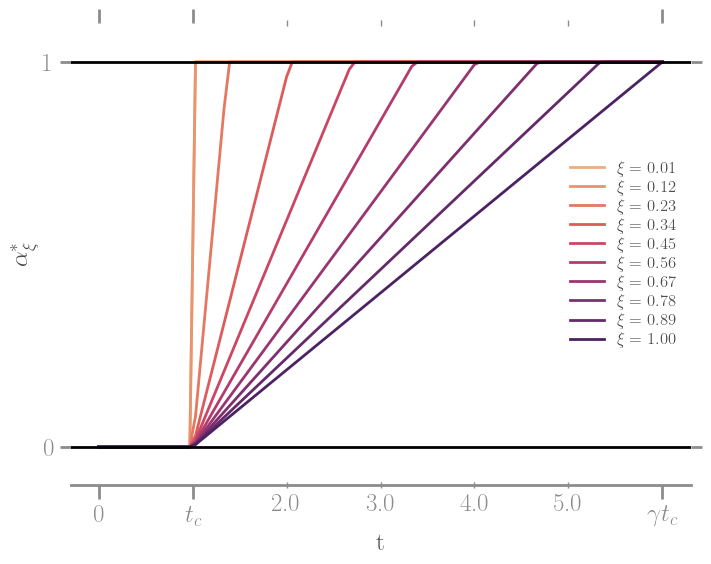

In [35]:
# sp.latex(

from visuals import *
parameters = _matpar.copy()

matplotlibdefaults(palette='light',useTex=True)

sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_loads = np.linspace(0., float(parameters['γ'] * tc), 100)
tc = model.critical_load(parameters)[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

_sequence = np.linspace(0.01, 1, 10)
palette = sns.color_palette("viridis", n_colors=10)
palette = sns.color_palette("Paired")
palette = sns.color_palette("rocket", as_cmap=True)
palette = sns.color_palette("flare", as_cmap=True)


for _xi in _sequence:
    parameters.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(parameters) for sol in sols]
    idx = model.positive_solution_wrt_t(_sols, parameters)
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    ax.plot(_loads, np.minimum(_f(_loads), 1), label=f'$\\xi = {_xi:.2f}$', color = palette(_xi))

plt.axhline(0, c='k')
plt.axhline(1, c='k')
plt.legend()
plt.ylabel('$\\alpha_\\xi^*$')
plt.xlabel('t')

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k')

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k')

plt.yticks([0, 1])
plt.ylim(-.1, 1.1)
setspines0()
# fig.savefig(os.path.join(output_dir, 'bifurcation-by-xi.png'))


<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/114006336.py:14: SyntaxWarning: invalid escape sequence '\g'
  x_tick_labels = [0, "$t_c$", "$\gamma t_c$", "$\gamma t_c/N$"]
/var/folders/ht/z8sb7wsd1bg0qpmyyfyq2rcm0000gr/T/ipykernel_72105/114006336.py:14: SyntaxWarning: invalid escape sequence '\g'
  x_tick_labels = [0, "$t_c$", "$\gamma t_c$", "$\gamma t_c/N$"]


0

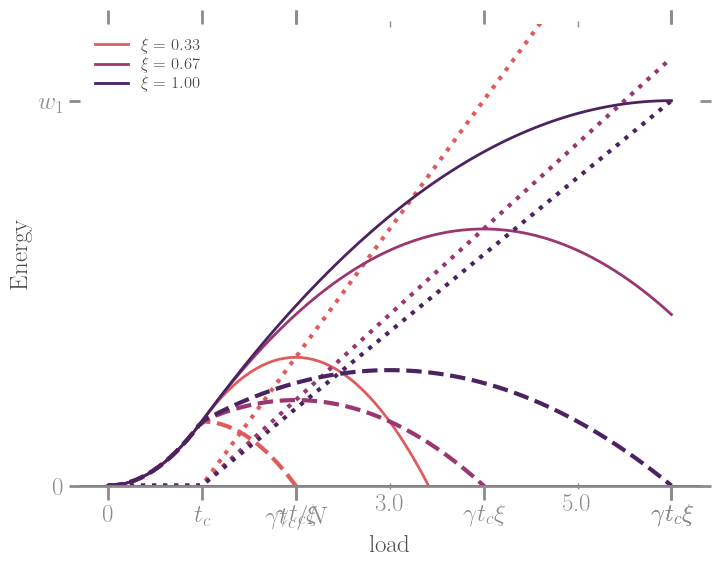

In [39]:
# Energy of bifurcated branches

parameters = _matpar.copy()

sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_loads = np.linspace(0., float(parameters['γ'] * tc), 100)
tc = model.critical_load(parameters)[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# _sequence = np.linspace(0.1, 1, 10)
_sequence = [n/parameters['N'] for n in range(1, parameters['N']+1)]
x_ticks = [0, float(tc), parameters['γ']*float(tc), parameters['γ']*float(tc)/parameters['N']]
x_tick_labels = [0, "$t_c$", "$\gamma t_c$", "$\gamma t_c/N$"]

for _xi in _sequence:
    parameters.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(parameters) for sol in sols]
    idx = model.positive_solution_wrt_t(_sols, parameters)

    _total_xi_energy = model.energy_xi_bifurcations().subs(parameters) \
        .subs({sp.Symbol('α^*'): 0})    \
        .replace(sp.Function('s'), model.model.s)      \
        .replace(sp.Function('w'), model.model.w)         \
        .subs('xi', _xi)                 \
        .subs(γ, parameters["γ"])


    _elastic_xi_energy = model.elastic_energy_xi_bifurcations().subs(parameters) \
        .subs({sp.Symbol('α^*'): 0})    \
        .replace(sp.Function('s'), model.model.s)      \
        .replace(sp.Function('w'), model.model.w)         \
        .subs('xi', _xi)                 \
        .subs(γ, parameters["γ"])

    _damage_xi_energy = model.damage_energy_xi_bifurcations().subs(parameters) \
        .subs({sp.Symbol('α^*'): 0})    \
        .replace(sp.Function('s'), model.model.s)      \
        .replace(sp.Function('w'), model.model.w)         \
        .subs('xi', _xi)                 \
        .subs(γ, parameters["γ"])

    _total_xi_energy_alpha = sp.lambdify((t, sp.Symbol('α_t')), _total_xi_energy, 'numpy')
    _elastic_xi_energy_alpha = sp.lambdify((t, sp.Symbol('α_t')), _elastic_xi_energy, 'numpy')
    _damage_xi_energy_alpha = sp.lambdify((t, sp.Symbol('α_t')), _damage_xi_energy, 'numpy')
    
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    alpha_t = _f(_loads)
    
    ax.plot(_loads,
            _total_xi_energy_alpha(_loads, alpha_t), 
            label=f'$\\xi = {_xi:.2f}$', color = palette(_xi))    
    ax.plot(_loads, _elastic_xi_energy_alpha(_loads, alpha_t), 
            lw =3, color = palette(_xi), ls='--')
    
    # ax.plot(_loads, 
    #     _total_xi_energy_alpha(_loads, alpha_t) - _elastic_xi_energy_alpha(_loads, alpha_t),
    #         lw =1, color = palette(_xi), ls='-', marker='o',
    #         )
    
    x_ticks += [parameters['γ']*float(tc)*_xi]
    x_tick_labels += [f"$\\gamma t_c \\xi$"]
    
    ax.plot(_loads, 
        _damage_xi_energy_alpha(_loads, alpha_t),
            lw =3, color = palette(_xi), ls=':', 
            )
    
plt.legend()
ax.set_ylabel('Energy')
ax.set_xlabel('load')

# ax.set_xticks([0, float(tc), parameters['γ']/parameters['N']*float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c/N$", "$\gamma t_c$"])
ax.set_xticks(x_ticks, x_tick_labels)
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k')

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k')

ax.set_yticks([0, parameters['w1']], [0, "$w_1$"])
ax.axhline(0, c='k')
ax.set_ylim([0, 1.2*parameters['w1']])
# ax.axhline(1, c='k', lw=3)
# model.xi_energy_m_bifurcations().subs(parameters).subs({sp.symbols('α_*'): 0})
setspines0()
# fig.savefig(os.path.join(output_dir, 'bifurcation-energy-xi.png'))


In [895]:
model.energy_fc_alpha().subs(subs_homog_α)    \
            .replace(sp.Function('a'), model.model.a) \
            .replace(sp.Function('s'), model.model.s)      \
            .replace(sp.Function('w'), model.model.w)  \
            .subs(parameters)
            
alpha = model.homogeneous_damage(parameters)
alpha

Piecewise((0.471404520791032*t - 0.333333333333333, t >= 0.707106781186548), (0, True))

Text(0.5, 0, 't')

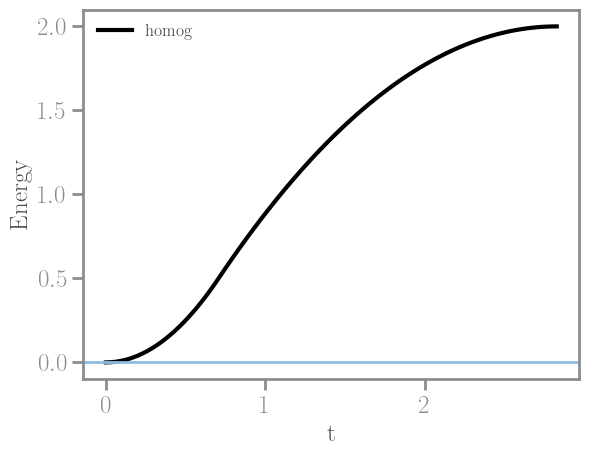

In [899]:
plt.plot(_loads, _en_homogeneous_t(_loads), c='k', label='homog', lw=3)
# plt.plot(_loads, _f(_loads), c='r', label='bifurcated', lw=3)
# plt.plot(_loads, _en_homogeneous_t(_loads) - _f(_loads), c='k', label='total', lw=3)
# plt.plot(_loads, _en_homogeneous_t(_loads) - _fd(_loads), c='k', label='damage', lw=3)
# plt.plot(_loads, _en_homogeneous_t(_loads) - _f(_loads), c='g', label='bif - homo', lw=3)
plt.axhline(0)
# plt.plot(_loads, , c='r', label='homog', lw=3)

plt.legend()
plt.ylabel('Energy')
plt.xlabel('t')

0

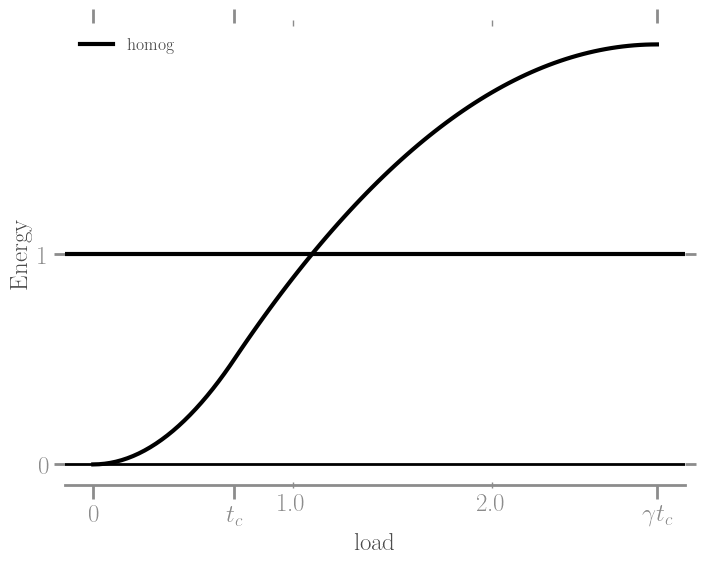

In [896]:




# atls = SymbolicDiscreteDamage(parameters, _N)
# model = ModelAnalysis(atls)



# Energy of bifurcated branches

parameters = _matpar.copy()
alpha = model.homogeneous_damage(parameters)

sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
_loads = np.linspace(0., float(parameters['γ'] * tc), 100)
tc = model.critical_load(parameters)[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

_sequence = np.linspace(0.1, 1, 10)

_en_homogeneous = model.energy_fc_alpha().subs(subs_homog_α)    \
            .replace(sp.Function('a'), model.model.a) \
            .replace(sp.Function('s'), model.model.s)      \
            .replace(sp.Function('w'), model.model.w)  \
            .subs(parameters)          \
    .subs({sp.symbols('α_t'): alpha})

_en_homogeneous_t = sp.lambdify(t, _en_homogeneous.subs(parameters), 'numpy')

ax.plot(_loads, _en_homogeneous_t(_loads), c='k', label='homog', lw=3)

for _xi in _sequence:
    parameters.update({sp.symbols('xi'): _xi})
    _sols = [sol.subs(parameters) for sol in sols]
    idx = model.positive_solution_wrt_t(_sols, parameters)

    _total_xi_energy = model.energy_xi_bifurcations().subs(_normalise) \
        .subs({sp.Symbol('α^*'): 0})    \
        .replace(sp.Function('s'), model.model.s)      \
        .replace(sp.Function('w'), model.model.w)         \
        .subs('xi', _xi)                 \
        .subs(γ, parameters["γ"])


    _elastic_xi_energy = model.elastic_energy_xi_bifurcations().subs(_normalise) \
        .subs({sp.Symbol('α^*'): 0})    \
        .replace(sp.Function('s'), atls.s)      \
        .replace(sp.Function('w'), model.model.w)         \
        .subs('xi', _xi)                 \
        .subs(γ, parameters["γ"])

    _total_xi_energy_alpha = sp.lambdify((t, sp.Symbol('α_t')), _total_xi_energy, 'numpy')
    _elastic_xi_energy_alpha = sp.lambdify((t, sp.Symbol('α_t')), _elastic_xi_energy, 'numpy')
    bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
    _f = sp.lambdify(t, bounded_sol, 'numpy')
    alpha_t = _f(_loads)
    
    # ax.plot(_loads, np.minimum(
    #         _en_homogeneous_t(_loads) - _total_xi_energy_alpha(_loads, alpha_t), 1), 
    #         label=f'$\\xi = {_xi:.2f}$', color = palette(_xi))    
    # ax.plot(_loads, _elastic_xi_energy_alpha(_loads, alpha_t), 
    #         # label=f'elastic $\\xi = {_xi:.2f}$', 
    #         lw =3, color = palette(_xi), ls='--')
    # ax.plot(_loads, np.minimum(
    #     _en_homogeneous_t(_loads) - _total_xi_energy_alpha(_loads, alpha_t) - _elastic_xi_energy_alpha(_loads, alpha_t),
    #     1), 
    #         lw =1, color = palette(_xi), ls='-', marker='o',
    #         # label=f'$\\xi = {_xi:.2f}$'
    #         )
plt.legend()
ax.set_ylabel('Energy')
ax.set_xlabel('load')

ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k')

ax.set_xticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
ax.tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k')

ax.set_yticks([0, 1])
ax.axhline(0, c='k')
# ax.set_ylim([0, 1.1])
ax.axhline(1, c='k', lw=3)
# model.xi_energy_m_bifurcations().subs(_normalise).subs({sp.symbols('α_*'): 0})
setspines0()
# fig.savefig(os.path.join(output_dir, 'bifurcation-energy-xi.png'))



### Stress of bifurcated branches

In [184]:
bif_subs_alpha, _ = model._state_bifurcation_substitutions(m)

In [181]:
model._state_split(m)


([α2], {α1, α3}, [e2], {e1, e3})

In [188]:
stress_bif = model._stress().subs(bif_subs_alpha)

E0*N*t/(L*(2*s(α^*) + s(α_t)))

In [214]:
def stress_m_bif(model, m):
    assert m <= model.matpar['N']
    bif_subs_alpha, _ = model._state_bifurcation_substitutions(m)
    stress_bif = model._stress().subs(bif_subs_alpha)
    return stress_bif

In [198]:
stress_m_bif(model, m=1)    \
    .subs({sp.symbols('α^*'): 0})   

E0*N*t/(L*(2*s(0) + s(α_t)))

In [ ]:
subs_homog_α, _ = model._state_homog_substitutions()
alpha = model.homogeneous_damage(_matpar)
_loads = np.linspace(0., float(parameters['γ'] * tc), 30)
stress = model._stress().subs(subs_homog_α) \
    .subs({sp.symbols('α_t'): alpha}) \
        .replace(sp.Function('s'), model.model.s) \
        .replace(sp.Function('w'), model.model.w) \
        .subs(_matpar)
        
stress_f = sp.lambdify(t, stress, 'numpy')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(_loads, stress_f(_loads), label='stress')
ax.set_xticks([0, float(tc), parameters['γ']*float(tc), parameters['γ']*float(tc)/parameters['N']], [0, "$t_c$", "$\gamma t_c$", "$\gamma t_c/N$"])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2, colors='k', labelsize=12)
    


In [205]:
bif_crit_m

-0.5*E0*N**2*m*t**2*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(-N*α_t + N + m*α_t*γ)**2) + 1.0*m*w1

In [226]:
_stress_h

3*t/(1.0*(5*α3 + 1)/(1 - α3) + 1.0*(5*α2 + 1)/(1 - α2) + 1.0*(5*α1 + 1)/(1 - α1))

In [235]:
model.bifurcation_m_criterion(a_subs = {sp.symbols('α^*'): 0})

-0.5*E0*N**2*m*t**2*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(-N*α_t + N + m*α_t*γ)**2) + 1.0*m*w1

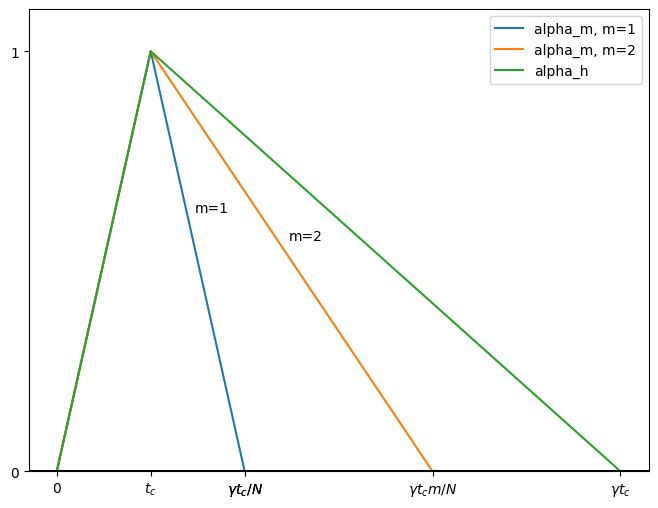

In [ ]:
parameters = _matpar.copy()
subs_homog_α, _ = model._state_homog_substitutions()

_loads = np.linspace(0., float(parameters['γ'] * tc), 31)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sols = sp.solve(bif_crit_m, sp.symbols('α_t'))

x_ticks = [0, float(tc), parameters['γ']*float(tc), parameters['γ']*float(tc)/parameters['N']]
x_tick_labels = [0, "$t_c$", "$\gamma t_c$", "$\gamma t_c/N$"]

for m in range(1, model.matpar['N']):
    alpha_m = alpha_m_bifurcations(model, m)
    _stress_m = stress_m_bif(model, m).subs({sp.symbols('α^*'): 0}) \
        .replace(sp.Function('s'), model.model.s)      \
        .replace(sp.Function('w'), model.model.w)   \
        .subs({sp.symbols('α_t'): alpha_m}) \
        .subs(parameters)
    
    stress_f = sp.lambdify(t, _stress_m, 'numpy')
    ax.plot(_loads, stress_f(_loads), label=f'alpha_m, m={m}',)
    
    idx = np.abs(stress_f(_loads) - .5).argmin()  # Index near x = 1.5 for placing the annotation
    ax.annotate(f'm={m:d}', xy=(_loads[idx], stress_f(_loads)[idx]), 
                xytext=(5, 5), textcoords='offset points')

    x_ticks += [parameters['γ']*float(tc)/parameters['N'] * m]
    if m == 1: x_tick_labels += [f"$\\gamma t_c/N$"]
    else: x_tick_labels += [f"$\\gamma t_c m/N$"]
    
alpha = model.homogeneous_damage(_matpar)
_stress_h = model._stress().subs({sp.symbols('α^*'): 0}) \
    .subs(subs_homog_α) \
    .replace(sp.Function('s'), model.model.s)      \
    .replace(sp.Function('w'), model.model.w)   \
    .subs({sp.symbols('α_t'): alpha}) \
    .subs(parameters)

stress_h = sp.lambdify(t, _stress_h, 'numpy')
ax.plot(_loads, stress_h(_loads), label=f'alpha_h',)


plt.legend()

ax.set_xticks(x_ticks, x_tick_labels)
ax.set_yticks([0, 1])
ax.set_ylim([0, 1.1])
ax.axhline(0, c='k')

plt.savefig(os.path.join(output_dir, 'stress-bifurcations.png'))


In [241]:
def alpha_m_bifurcations(model, m):
    assert m < model.matpar['N']
    bif_subs_alpha, _ = model._state_bifurcation_substitutions(m)
    bif_crit_m = model.bifurcation_m_criterion(a_subs = {sp.symbols('α^*'): 0})
    sols = sp.solve(bif_crit_m, sp.symbols('α_t'))
    _sols = [sol.subs(parameters).subs({sp.symbols('m'): m}) for sol in sols]
    # print(_sols)
    idx = model.positive_solution_wrt_t(_sols, parameters)
    _alpha_m = sols[idx].subs(parameters).subs({sp.symbols('m'): m})
    tc = model.critical_load(parameters)[0]
    alpha_m = sp.Piecewise((_alpha_m, t >= tc), (0, t < tc))

    # alpha_m = model.model.a(t).subs(bif_subs_alpha)
    return alpha_m

In [242]:
alpha_m_bifurcations(model, 2)

Piecewise((0.235702260395516*sqrt(2)*t - 0.333333333333333, t >= 0.707106781186547*sqrt(2)), (0, True))

In [261]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Define the function to plot the lines
def line(x, m):
    return m * (x - 1) + 1

# Define the function to update the plot
def update_plot(m):
    x = np.linspace(0, 2, 100)
    y = line(x, m)
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label=f'm={m:.2f}')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(1, color='black', linewidth=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Interactive Plot with Parameter m')
    plt.legend()
    plt.grid(True)
    plt.ylim(-1, 3)
    plt.show()

# Create an interactive slider
interact(update_plot, m=FloatSlider(value=1, min=0.1, max=2, step=0.1, description='m'))


### Stability of homogeneous evolutions

In [41]:
sp.diff(model.homogeneous_energy_fc_alpha(), sp.symbols('α_t'), 2)


0.5*E0*t**2*Derivative(a(α_t), (α_t, 2))/L**2 + w1*Derivative(w(α_t), (α_t, 2))

In [42]:
_energy_homog = model.homogeneous_energy_fc_alpha()    \
                .replace(sp.Function('w'), model.model.w)  \
                .replace(sp.Function('s'), model.model.s)
                # .replace(sp.Function('a'), model.model.a) \

_energy_homog      

0.5*E0*t**2*a(α_t)/L**2 + w1*α_t

In [44]:
_normalise

{E0: 1, w1: 1, L: 1}

In [45]:
small_hessian = sp.hessian(model.energy_fc_alpha().apart(sp.symbols('t'))
    , model.state["α"])

small_hessian

Matrix([
[1.0*E0*L**4*N*t**2*Derivative(s(α1), α1)**2/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**3 - 0.5*E0*L**2*N*t**2*Derivative(s(α1), (α1, 2))/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**2 + w1*Derivative(w(α1), (α1, 2))/N,                                                                                                                      1.0*E0*L**4*N*t**2*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**3,                                                                                                                      1.0*E0*L**4*N*t**2*Derivative(s(α1), α1)*Derivative(s(α3), α3)/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**3],
[                                                                                                                     1.0*E0*L**4*N*t**2*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**3, 1.0*E0*L**4*N*t**2*Derivative(s(α2), α2)**2/(1.0

In [50]:
small_hessian[0, 0].args[0]

w1*Derivative(w(α1), (α1, 2))/N

In [52]:
small_hessian[0, 0].args[1].simplify()

1.0*E0*N*t**2*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2) + s(α3))**3)

In [53]:
small_hessian[0, 0].args[2].simplify()

-0.5*E0*N*t**2*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2) + s(α3))**2)

In [102]:
1/2 * E0 * N * t**2 * sp.diff(atls._s(sp.symbols('α_t')), sp.symbols('α_t'), 2) / (L**2 * (N * atls._s(sp.symbols('α_t')))**2)

0.5*E0*t**2*Derivative(s(α_t), (α_t, 2))/(L**2*N*s(α_t)**2)

In [103]:
1/2 * E0 * N * t**2 * 2 * sp.diff(atls._s(sp.symbols('α_t')), sp.symbols('α_t'), 1)**2 / (L**2 * (N * atls._s(sp.symbols('α_t')))**3)

1.0*E0*t**2*Derivative(s(α_t), α_t)**2/(L**2*N**2*s(α_t)**3)

In [119]:
_small_hessian = small_hessian

_hii_1 = 1/2 * E0 * N * t**2 * sp.diff(atls._s(sp.symbols('α_t')), sp.symbols('α_t'), 2) / (L**2 * (N * atls._s(sp.symbols('α_t')))**2)
_hii_2 = 1/2 * E0 * N * t**2 * 2 * sp.diff(atls._s(sp.symbols('α_t')), sp.symbols('α_t'), 1)**2 / (L**2 * (N * atls._s(sp.symbols('α_t')))**3)
_hii_3 = w1 * sp.diff(atls._w(sp.symbols('α_t')), sp.symbols('α_t'), 2) / N

_hii = _hii_1 + _hii_2 + _hii_3
_hij = E0 * L**4 * N * t**2 * sp.diff(atls._s(sp.symbols('α_i')), sp.symbols('α_i'), 1)* sp.diff(atls._s(sp.symbols('α_j')), sp.symbols('α_j'), 1) / (L**2 * (N * atls._s(sp.symbols('α_t')))**2)



In [120]:
_small_hessian

Matrix([
[0.5*E0*t**2*Derivative(s(α_t), (α_t, 2))/(L**2*N*s(α_t)**2) + 1.0*E0*t**2*Derivative(s(α_t), α_t)**2/(L**2*N**2*s(α_t)**3) + w1*Derivative(w(α_t), (α_t, 2)),                                                                                                                      1.0*E0*L**4*N*t**2*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**3,                                                                                                                      1.0*E0*L**4*N*t**2*Derivative(s(α1), α1)*Derivative(s(α3), α3)/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**3],
[                                        1.0*E0*L**4*N*t**2*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**3, 1.0*E0*L**4*N*t**2*Derivative(s(α2), α2)**2/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**3 - 0.5*E0*L**2*N*t**2*Derivative(s(α2), (α2, 2))/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**2 + 

In [121]:
small_hessian[0, 1]

1.0*E0*L**4*N*t**2*Derivative(s(α1), α1)*Derivative(s(α2), α2)/(1.0*L**2*s(α1) + 1.0*L**2*s(α2) + 1.0*L**2*s(α3))**3

In [131]:
((_hii_1 + _hii_2) * atls._s(sp.symbols('α_t'))**2).simplify().replace(sp.Function('s'), atls.s).doit()

1.0*E0*t**2*(1 - w(α_t))*(0.5*N*((γ - 1)*w(α_t) + 1)*(-1.0*(γ - 1)*Derivative(w(α_t), (α_t, 2)) + 2.0*(γ - 1)*Derivative(w(α_t), α_t)**2/(w(α_t) - 1) + 1.0*((γ - 1)*w(α_t) + 1)*(Derivative(w(α_t), (α_t, 2)) - 2*Derivative(w(α_t), α_t)**2/(w(α_t) - 1))/(w(α_t) - 1))/((1 - w(α_t))*(w(α_t) - 1)) + 1.0*(1.0*(γ - 1)*Derivative(w(α_t), α_t)/(1 - w(α_t)) + 1.0*((γ - 1)*w(α_t) + 1)*Derivative(w(α_t), α_t)/(1 - w(α_t))**2)**2)/(L**2*N**2*((γ - 1)*w(α_t) + 1))

In [117]:
_hii.replace(sp.Function('s'), atls.s).replace(sp.Function('w'), model.model.w).simplify()

(1.0*E0*N*t**2*(α_t*(γ - 1) + 1)*(γ - 1 - (α_t*(γ - 1) + 1)/(α_t - 1)) - 1.0*E0*t**2*(α_t - 1)**3*(1.0*(1 - γ)/(α_t - 1) - 1.0*(-α_t*(γ - 1) - 1)/(α_t - 1)**2)**2)/(L**2*N**2*(α_t*(γ - 1) + 1)**3)

In [57]:
small_hessian[0, 0] = sum([args.simplify() for args in small_hessian[0, 0].args])

In [61]:
small_hessian[0, 0].args[0] \
    .replace(sp.Function('w'), model.model.w).doit()

0

In [65]:
small_hessian[0, 0].args[1] \
    .replace(sp.Function('s'), model.model.s)   \
    .replace(sp.Function('w'), model.model.w).doit()

1.0*E0*N*t**2*(1.0*(γ - 1)/(1 - α1) + 1.0*(α1*(γ - 1) + 1)/(1 - α1)**2)**2/(L**2*(1.0*(α3*(γ - 1) + 1)/(1 - α3) + 1.0*(α2*(γ - 1) + 1)/(1 - α2) + 1.0*(α1*(γ - 1) + 1)/(1 - α1))**3)

In [66]:
homog_alpha_subs, _ = model._state_homog_substitutions()

In [70]:
small_hessian[0, 0].args[1] \
    .replace(sp.Function('s'), model.model.s)   \
    .replace(sp.Function('w'), model.model.w).doit()    \
    .subs(homog_alpha_subs).simplify()

-0.037037037037037*E0*N*t**2*γ**2/(L**2*α_t*(α_t*γ - α_t + 1)**3 - L**2*(α_t*γ - α_t + 1)**3)

In [72]:
small_hessian[0, 0].args[2] \
    .replace(sp.Function('s'), model.model.s)   \
    .replace(sp.Function('w'), model.model.w).doit()    \
    .subs(homog_alpha_subs).simplify()

0.111111111111111*E0*N*t**2*γ/(L**2*α_t*(α_t*γ - α_t + 1)**2 - L**2*(α_t*γ - α_t + 1)**2)

In [80]:
small_hessian[0,0].args

(w1*Derivative(w(α1), (α1, 2))/N,
 1.0*E0*N*t**2*Derivative(s(α1), α1)**2/(L**2*(s(α1) + s(α2) + s(α3))**3),
 -0.5*E0*N*t**2*Derivative(s(α1), (α1, 2))/(L**2*(s(α1) + s(α2) + s(α3))**2))

In [ ]:
import sympy as sp

# Define the symbols
A, B, C = sp.symbols('A B C')

# Define the matrix dimensions (for example, a 3x3 matrix)
n = 3

# Construct the matrix
matrix = sp.Matrix(n, n, lambda i, j: (A**2 - B**2) if i == j else C**2)

# Display the matrix
sp.pretty_print(matrix)

# Compute the eigenvalues of the matrix
eigenvalues = matrix.eigenvals()

# Display the eigenvalues
sp.pretty_print(eigenvalues)


TypeError: unsupported operand type(s) for /: 'Derivative' and 'function'

In [92]:
homog_alpha_subs

{α1: α_t, α2: α_t, α3: α_t}

In [950]:
H_ii = small_hessian[0,0] \
    .replace(sp.Function('s'), model.model.s)    \
    .replace(sp.Function('w'), model.model.w)    \
    .subs(homog_alpha_subs).doit().simplify()

In [953]:
num, den = sp.fraction(H_ii)
num.simplify().factor()

0.25*N*t**2*γ*(1.0*α_t*γ - 1.0*α_t - 0.5*γ + 1.0)

In [957]:
sp.solve(num, sp.symbols('α_t'))[0].subs(parameters)

0.333333333333333

In [956]:
parameters

{'N': 2, 'γ': 4, 'E0': 2, 'w1': 2, 'L': 1, xi: 1.0}

Text(0, 0.5, '$H_{ii}$')

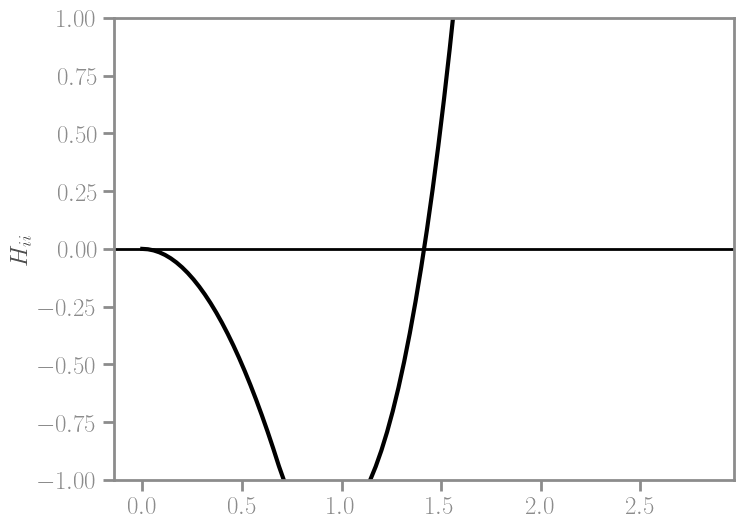

In [973]:
alpha = model.homogeneous_damage(parameters)
num, den = sp.fraction(H_ii)
h_ii = num.simplify().factor() \
    .subs(sp.symbols('α_t'), alpha)  \
    .subs(parameters)
    
h_ii_f = sp.lambdify(sp.symbols('t'), h_ii, 'numpy')
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(_loads, h_ii_f(_loads), c='k', lw=3)
plt.axhline(0, c='k')
ax.set_ylim(-1, 1)
ax.set_ylabel('$H_{ii}$')

In [971]:
h_ii_f(_loads)

array([-0.00000000e+00, -1.63248648e-03, -6.52994592e-03, -1.46923783e-02,
       -2.61197837e-02, -4.08121620e-02, -5.87695133e-02, -7.99918376e-02,
       -1.04479135e-01, -1.32231405e-01, -1.63248648e-01, -1.97530864e-01,
       -2.35078053e-01, -2.75890215e-01, -3.19967350e-01, -3.67309458e-01,
       -4.17916539e-01, -4.71788593e-01, -5.28925620e-01, -5.89327620e-01,
       -6.52994592e-01, -7.19926538e-01, -7.90123457e-01, -8.63585348e-01,
       -9.40312213e-01, -1.00999795e+00, -1.04782546e+00, -1.08189331e+00,
       -1.11180574e+00, -1.13716700e+00, -1.15758132e+00, -1.17265297e+00,
       -1.18198617e+00, -1.18518519e+00, -1.18185425e+00, -1.17159762e+00,
       -1.15401953e+00, -1.12872424e+00, -1.09531598e+00, -1.05339900e+00,
       -1.00257756e+00, -9.42455882e-01, -8.72638228e-01, -7.92728839e-01,
       -7.02331962e-01, -6.01051841e-01, -4.88492722e-01, -3.64258852e-01,
       -2.27954476e-01, -7.91838392e-02,  8.24488122e-02,  2.57339233e-01,
        4.45883176e-01,  

In [916]:
small_hess = sp.hessian(_energy_homog, model.state["α"])
small_hess.simplify()
small_hess

Matrix([
[0, 0],
[0, 0]])

### Stability of bifurcated solutions

In [1017]:
m

1

In [976]:
sols = sp.solve(bif_crit_xi, sp.symbols('α_t'))
bif_crit_xi

-0.5*E0*t**2*xi*(α_t - 1)**2*(1.0*α_t*γ/(α_t - 1)**2 - 1.0*α_t/(α_t - 1)**2 - 1.0*γ/(α_t - 1) + 1.0/(α_t - 1) + 1.0/(α_t - 1)**2)/(L**2*(xi*α_t*γ - α_t + 1)**2) + 1.0*w1*xi

In [984]:
sp.posify(sp.diff(sols[0], sp.symbols('t')))[0]

-1.4142135623731*sqrt(_E0)*sqrt(_w1)*sqrt(_γ)/(2.0*_L*_w1*_xi*_γ - 2.0*_L*_w1)

In [990]:
parameters.update({'xi': .1})
_sols = [sol.subs(parameters) for sol in sols]
idx = model.positive_solution_wrt_t(_sols, parameters)
bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))
bounded_sol

Piecewise((2.35702260395516*t + 1.66666666666667, t >= 0.707106781186548), (0, True))

In [1012]:
bif_crit_m = sp.diff(
    model.energy_m_bifurcations()   \
    .replace(sp.Function('s'), model.model.s)      \
    .replace(sp.Function('w'), model.model.w)        
    .subs({sp.symbols('α^*'): 0}) \
    , sp.symbols('α_t'))    \
    # .simplify()
bif_crit_m

0.5*E0*N**2*t**2*(-1.0*m*(γ - 1)/(1 - α_t) - 1.0*m*(α_t*(γ - 1) + 1)/(1 - α_t)**2)/(L**2*(1.0*N - 1.0*m + 1.0*m*(α_t*(γ - 1) + 1)/(1 - α_t))**2) + m*w1

In [1016]:
sols[0].subs(parameters)

(-11.3137084989848*t - 8.0)/(16.0*m - 8.0)

In [1024]:
sols = sp.solve(bif_crit_m, sp.symbols('α_t'))
# sols[0].collect(sp.symbols('t'))
_sols = [sol.subs(parameters).subs({sp.symbols('m'): m}) for sol in sols]
idx = model.positive_solution_wrt_t(_sols, parameters)
sols[idx]

(-2.0*L*N*w1 + 1.4142135623731*N*t*sqrt(E0*w1*γ))/(-2.0*L*N*w1 + 2.0*L*m*w1*γ)

In [1026]:
# Bifurcated solution

_sols[idx]
bounded_sol = sp.Piecewise((_sols[idx], t >= tc), (0, t < tc))

bounded_sol

Piecewise((1.4142135623731*t - 1.0, t >= 0.707106781186548), (0, True))

In [1033]:
parameters

{'N': 2, 'γ': 4, 'E0': 2, 'w1': 2, 'L': 1, xi: 1.0, 'xi': 0.1}

In [1051]:
model._state_split(m)[0][0]

α2

In [1055]:
bif_alpha_subs, _ = model._state_bifurcation_substitutions(m)
bif_alpha_subs

{α2: α_t, α1: α^*}

In [1053]:
homog_alpha_subs

{α1: α_t, α2: α_t}

In [1059]:
H_ii = small_hessian[0,0] \
    .replace(sp.Function('s'), model.model.s)    \
    .replace(sp.Function('w'), model.model.w)    \
    .doit().simplify()
    
H_ii = H_ii.subs(bif_alpha_subs)   \
    .subs({sp.symbols('α^*'): 0}) \
    .simplify()    \
# .subs(model._state_bifurcation_substitutions(m))
H_ii

-1.0*N*t**2*γ*(α_t - 1)**2*(α_t*(γ - 1) - α_t + 1.0*γ*(α_t - 1) + 2)/(α_t*(γ - 1) - α_t + 2)**3

Text(0, 0.5, '$H_{ii}(y_m)$')

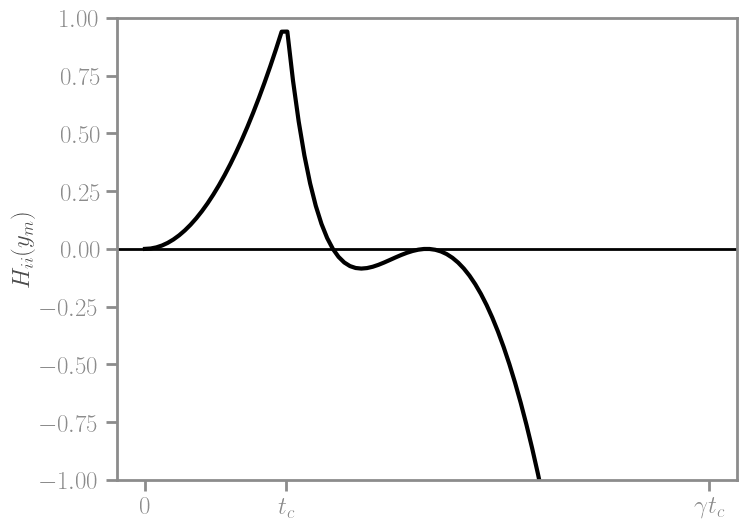

In [1067]:
H_ii.subs({sp.symbols('α_t'): bounded_sol}).subs(parameters)
_Hii_t = sp.lambdify(sp.symbols('t'), 
                    H_ii.subs({sp.symbols('α_t'): bounded_sol}).subs(parameters), 'numpy')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(_loads, _Hii_t(_loads), c='k', lw=3)
plt.axhline(0, c='k')
ax.set_xticks([0, float(tc), parameters['γ']*float(tc)], [0, "$t_c$", "$\gamma t_c$"])
ax.set_ylim(-1, 1)
ax.set_ylabel('$H_{ii}(y_m)$')

### Material behaviour

<lambdifygenerated-103>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 1.0*(5*α + 1)/(1 - α)
<lambdifygenerated-104>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 5.0/(1 - α) + 1.0*(5*α + 1)/(1 - α)**2
<lambdifygenerated-105>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 2.0*(5 - (5*α + 1)/(α - 1))/(α - 1)**2


(0.0, 15.600000000000001)

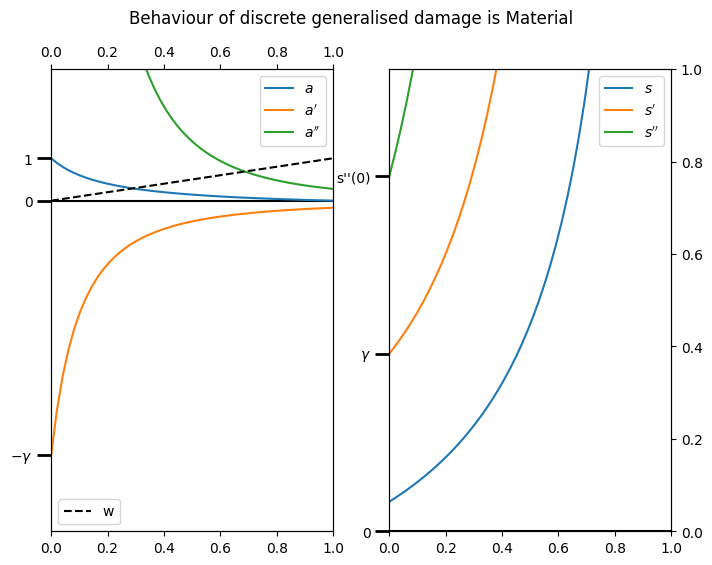

In [39]:
atls = SymbolicDiscreteDamage(_matpar)
model = ModelAnalysis(atls)
(model.criterion()).subs(_matpar)

fig, ax = atls._plot_material(_matpar)

app_zero = sp.diff(atls.a(sp.symbols('α'))   \
    .replace(sp.Function('w'), atls.w),
    sp.symbols('α'), 2).simplify().subs(sp.symbols('α'), 0)

spp_zero = sp.diff(atls.s(sp.symbols('α'))   \
    .replace(sp.Function('w'), atls.w),
    sp.symbols('α'), 2).simplify().subs(sp.symbols('α'), 0)

ax[1].set_yticks([0, _matpar['γ'], float(spp_zero.subs(_matpar))], [0, "$\gamma$", "s''(0)"])
ax[1].tick_params(axis='y', which='major', direction='out', length=10, width=2, colors='k')

ax[0].set_yticks([0, -_matpar['γ'], 1, float(app_zero.subs(_matpar))], [0, "$-\gamma$", 1, "$a''(0)$"])
ax[0].tick_params(axis='y', which='major', direction='out', length=10, width=2, colors='k')

# ax[1].set_yticks(np.arange(0.0, parameters['γ']*float(tc)), np.arange(0.0, parameters['γ']*float(tc)), minor=True)
# ax[1].tick_params(axis='x', which='minor', direction='inout', length=5, width=1, colors='k')

ax[0].set_ylim(-1.3*_matpar['γ'], 3.1)
ax[1].set_ylim(0, 1.3*float(spp_zero.subs(_matpar)))

In [30]:
app_zero = sp.diff(atls.a(sp.symbols('α'))   \
    .replace(sp.Function('w'), atls.w),
    sp.symbols('α'), 2).simplify().subs(sp.symbols('α'), 0)
app_zero.subs(_matpar)

60

In [34]:
spp_zero = sp.diff(atls.s(sp.symbols('α'))   \
    .replace(sp.Function('w'), atls.w),
    sp.symbols('α'), 2).simplify().subs(sp.symbols('α'), 0)
# spp_zero.subs(_matpar)
spp_zero

2.0*γ